In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.optimize import fmin_l_bfgs_b as minimize

sns.set_style('darkgrid', {'font.family': 'sans-serif', 'lines.width': 0.05})
sns.set_context('poster')


# X is a 1000 x 2 array (1000 data points with 2 features)
X = np.loadtxt('X.txt')
# y is a 1000 length binary vector with class labels
y = np.loadtxt('y.txt')

In [2]:
class LaplaceApproximation:
    def __init__(self, fit_intercept=True, split=0.5, rbf_length=None, prior_var=1, grid_search=False):
        self.split = split
        self.rbf_length = rbf_length
        self.prior_var = prior_var
        self.fit_intercept = fit_intercept
        self.grid_search = grid_search
    
    def __add_intercept(self, X):
        
        intercept = np.ones((X.shape[0], 1))
        
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    def __expand(self, X, Z, l):
        X2 = np.sum(X**2, 1)
        Z2 = np.sum(Z**2, 1)
        ones_X = np.ones(X.shape[0])
        ones_Z = np.ones(Z.shape[0])
        r2 = np.outer(X2, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z2)
        return np.exp((-0.5 / l**2) * r2)
    
    def fit(self, X, y):
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.split, random_state=42069)
        
        self.X_train_plot = self.X_train.copy()
        self.X_test_plot = self.X_test.copy()

        if not self.rbf_length == None:
            self.X_test = self.__expand(self.X_test, self.X_train, self.rbf_length)
            self.X_train = self.__expand(self.X_train, self.X_train, self.rbf_length)

        if self.fit_intercept:
            self.X_train = self.__add_intercept(self.X_train)
            self.X_test = self.__add_intercept(self.X_test)

        self.prior = (np.zeros(self.X_train.shape[1]), np.eye(self.X_train.shape[1])*self.prior_var)
        
        self.map_est, val, iter_dict = minimize(self.minimize_func, x0=np.zeros(self.X_train.shape[1]), fprime=None)
        
        self.theta=self.map_est
        self.hessian = self.calculate_hess()
        self.post_approx = (self.map_est, np.linalg.inv(self.hessian))
    
    def predict_prob(self, X):
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def calculate_hess(self):
        sum_mat = np.linalg.inv(self.prior[1])
        for i in range(len(self.y_train)):
            sum_mat += self.__sigmoid(np.dot(self.X_train[i,:], self.map_est))*(1-self.__sigmoid(np.dot(self.X_train[i,:], self.map_est)))*np.outer(self.X_train[i,:], self.X_train[i,:])
        return sum_mat
            
    def predict_approx(self, X):
        
        mu = np.matmul(X, self.post_approx[0])
        
        var = np.diagonal(np.matmul(X, np.matmul(self.post_approx[1], X.T)))
        
        kappa = (1 + np.pi*var/8)**(-0.5)
        
        return self.__sigmoid(mu*kappa)
    
    def minimize_func(self, params):
    
        values = self.__sigmoid(np.dot(self.X_train, params))
        
        gradient = np.matmul(np.linalg.inv(self.prior[1]), (self.prior[0] - params)) + np.matmul(self.X_train.T, (self.y_train - values))
        
        return -np.sum(self.y_train * np.log(values) + (1 - self.y_train) * np.log(1 - values))\
                + 0.5*np.matmul(np.matmul((params-self.prior[0]).T, np.linalg.inv(self.prior[1])),(params-self.prior[0]))\
                , -gradient
        
    def compute_ll(self, X, y):
            
        output_prob = self.predict_approx(X)
            
        return np.mean(y * np.log(output_prob) + (1 - y) * np.log(1 - output_prob))
    
    def model_evidence(self):
        #Need to add back in constant terms we removed during the minimisation
        logs = -self.minimize_func(self.post_approx[0])[0] - 0.5*self.X_train.shape[1]*np.log(self.prior_var)
        # 0.5 * 2 factor below omitted
        hess_det = -np.sum(np.log(np.diag(np.linalg.cholesky(self.hessian))))
        
        return logs + hess_det
    
    def plot_ll(self):
        ll = self.test_history
        ll2 = self.train_history
        plt.figure(figsize=(12,10))
        ax = plt.gca()
        plt.xlim(0, len(ll) + 2)
        plt.ylim(min(ll2) - 0.1, max(ll2) + 0.1)
        ax.plot(np.arange(1, len(ll) + 1), ll, '#ff4d4d', label="test")
        ax.plot(np.arange(1, len(ll2) + 1), ll2, '#6677ff', label="train")
        plt.xlabel('Steps')
        plt.ylabel('Average log-likelihood')
        plt.title('Average Log-likelihood Curve')
        plt.legend()
        plt.show()
        
    def plot_data_internal(self, X, y):
        x_min, x_max = -3, 3
        y_min, y_max = -3, 2
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))
        plt.figure(figsize=(12,10))
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        ax = plt.gca()
        ax.scatter(X[y == 0, 0], X[y == 0, 1], color='#6677ff', marker='.', label = 'Class 1', zorder=5)
        ax.scatter(X[y == 1, 0], X[y == 1, 1], color='#ff4d4d', marker='.', label = 'Class 2', zorder=10)
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.title('Scatter plot of dataset with contour')
        plt.legend(loc = 'upper left', scatterpoints = 1, numpoints = 1)
        return xx, yy
        
    def plot_contour(self, X, plot, y):
        xx, yy = self.plot_data_internal(plot, y)
        ax = plt.gca()
            
        X_predict = np.concatenate((xx.ravel().reshape((-1, 1)),
                                    yy.ravel().reshape((-1, 1))), 1)
        
        if not self.rbf_length == None:
            X_predict = self.__expand(X_predict, self.X_train_plot, self.rbf_length)
        
        X_predict = np.concatenate((np.ones((X_predict.shape[0], 1)), X_predict), 1)
        
        cmap = sns.cubehelix_palette(light=1, as_cmap=True)
        
        Z = self.predict_approx(X_predict)
        Z = Z.reshape(xx.shape)
        cs2 = ax.contour(xx, yy, Z, 20, cmap = 'coolwarm', linewidths = 3, zorder=1)
        #cs2 = ax.contourf(xx, yy, Z, cmap = 'coolwarm', zorder=1)
        plt.clabel(cs2, fmt = '%2.2f', colors = 'k', fontsize = 14)
        plt.show()
    
    def confusion(self, X, y):
        
        preds = self.predict(X, 0.5)
        
        return confusion_matrix(y, preds, labels=[False, True]) / len(y)
    
    def predict(self, X, threshold):
        return self.predict_approx(X) >= threshold

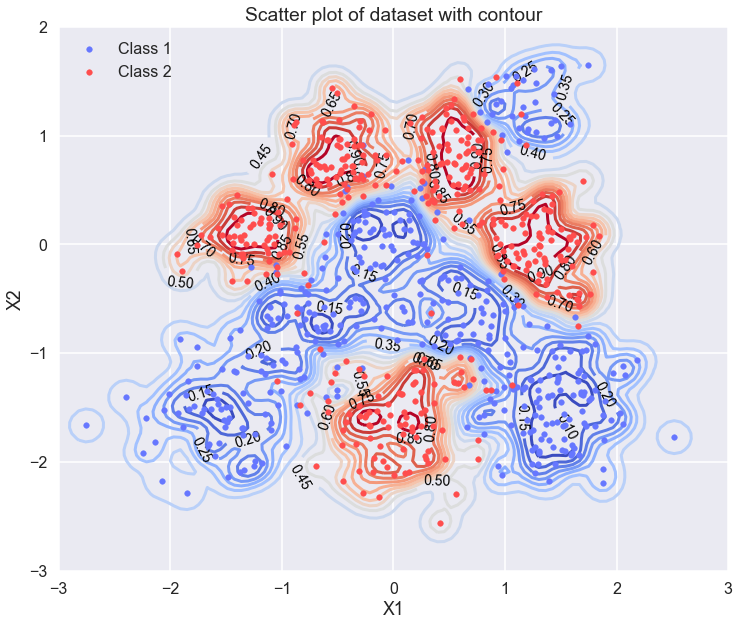

[[0.49 0.03]
 [0.07 0.41]]
-0.2597643929558259
-0.33391849237079235


In [3]:
model = LaplaceApproximation(rbf_length=0.1, split=0.2, prior_var=1)
model.fit(X, y)

model.plot_contour(model.X_train, model.X_train_plot, model.y_train)

print(model.confusion(model.X_test, model.y_test))

print(model.compute_ll(model.X_train, model.y_train))
print(model.compute_ll(model.X_test, model.y_test))

Bayesian: train=-0.2598, test=-0.3339, evidence=-319.88, confusion: 0.49, 0.03, 0.07, 0.41

MAP: train=-0.2208, test=-0.3078, confusion the same

In [4]:
model.hessian

array([[9.55325166e+001, 3.15833843e-001, 5.86437842e-001, ...,
        4.77006599e-001, 4.04832369e-001, 4.21537772e-001],
       [3.15833843e-001, 1.22025610e+000, 5.80176827e-024, ...,
        1.89188773e-112, 6.44617857e-096, 2.84832492e-105],
       [5.86437842e-001, 5.80176827e-024, 1.32832730e+000, ...,
        1.57910183e-035, 3.25297161e-054, 1.50684799e-031],
       ...,
       [4.77006599e-001, 1.89188773e-112, 1.57910183e-035, ...,
        1.22886881e+000, 5.74656523e-081, 1.55185860e-001],
       [4.04832369e-001, 6.44617857e-096, 3.25297161e-054, ...,
        5.74656523e-081, 1.16944210e+000, 1.16871206e-078],
       [4.21537772e-001, 2.84832492e-105, 1.50684799e-031, ...,
        1.55185860e-001, 1.16871206e-078, 1.21435650e+000]])

In [5]:
def construct_grid():
        ell = np.linspace(-1.8, 0, 10)
        sigma = np.linspace(-0.8, 1, 10)
        
        xx, yy = np.meshgrid(ell, sigma)
        
        positions = list(zip(xx.ravel(), yy.ravel()))
        
        return positions

Current values: 
l: 0.015848931924611134 sigma: 0.15848931924611134
Model evidence: 
-553.8900634620819
[-553.8900634620819]



Current values: 
l: 0.025118864315095794 sigma: 0.15848931924611134
Model evidence: 
-549.8576729277289
[-553.8900634620819, -549.8576729277289]



Current values: 
l: 0.039810717055349734 sigma: 0.15848931924611134
Model evidence: 
-536.976965205377
[-553.8900634620819, -549.8576729277289, -536.976965205377]



Current values: 
l: 0.06309573444801933 sigma: 0.15848931924611134
Model evidence: 
-496.20886346775575
[-553.8900634620819, -549.8576729277289, -536.976965205377, -496.20886346775575]



Current values: 
l: 0.1 sigma: 0.15848931924611134
Model evidence: 
-408.3781152536189
[-553.8900634620819, -549.8576729277289, -536.976965205377, -496.20886346775575, -408.3781152536189]



Current values: 
l: 0.15848931924611134 sigma: 0.15848931924611134
Model evidence: 
-302.6021385088812
[-553.8900634620819, -549.8576729277289, -536.976965205377, -496.20886346775

Current values: 
l: 0.1 sigma: 0.3981071705534972
Model evidence: 
-357.5391373105263
[-553.8900634620819, -549.8576729277289, -536.976965205377, -496.20886346775575, -408.3781152536189, -302.6021385088812, -228.69521731861937, -198.34736972230587, -200.4419619925808, -265.0913148125248, -553.2296129174194, -547.3835594986357, -529.3997544373074, -477.7465278466974, -381.88165765765905, -281.3236177676833, -217.51226389652714, -192.4724112567032, -193.87120997167978, -247.89434708816788, -552.5574175544173, -544.3367587018247, -520.1981022353118, -457.85454500348095, -357.5391373105263]



Current values: 
l: 0.15848931924611134 sigma: 0.3981071705534972
Model evidence: 
-264.49658812415
[-553.8900634620819, -549.8576729277289, -536.976965205377, -496.20886346775575, -408.3781152536189, -302.6021385088812, -228.69521731861937, -198.34736972230587, -200.4419619925808, -265.0913148125248, -553.2296129174194, -547.3835594986357, -529.3997544373074, -477.7465278466974, -381.88165765765905,

Current values: 
l: 0.25118864315095807 sigma: 0.6309573444801934
Model evidence: 
-205.94799920764243
[-553.8900634620819, -549.8576729277289, -536.976965205377, -496.20886346775575, -408.3781152536189, -302.6021385088812, -228.69521731861937, -198.34736972230587, -200.4419619925808, -265.0913148125248, -553.2296129174194, -547.3835594986357, -529.3997544373074, -477.7465278466974, -381.88165765765905, -281.3236177676833, -217.51226389652714, -192.4724112567032, -193.87120997167978, -247.89434708816788, -552.5574175544173, -544.3367587018247, -520.1981022353118, -457.85454500348095, -357.5391373105263, -264.49658812415, -210.1033725402505, -189.2639499820008, -189.76928391360633, -233.4557848482082, -552.1955638046288, -541.022856353758, -509.9584117670371, -438.04807791063416, -336.5999357123817, -252.12953354839624, -205.94799920764243]



Current values: 
l: 0.3981071705534973 sigma: 0.6309573444801934
Model evidence: 
-188.27044283559565
[-553.8900634620819, -549.8576729277289, -5

Current values: 
l: 0.15848931924611134 sigma: 1.0
Model evidence: 
-243.97890558609208
[-553.8900634620819, -549.8576729277289, -536.976965205377, -496.20886346775575, -408.3781152536189, -302.6021385088812, -228.69521731861937, -198.34736972230587, -200.4419619925808, -265.0913148125248, -553.2296129174194, -547.3835594986357, -529.3997544373074, -477.7465278466974, -381.88165765765905, -281.3236177676833, -217.51226389652714, -192.4724112567032, -193.87120997167978, -247.89434708816788, -552.5574175544173, -544.3367587018247, -520.1981022353118, -457.85454500348095, -357.5391373105263, -264.49658812415, -210.1033725402505, -189.2639499820008, -189.76928391360633, -233.4557848482082, -552.1955638046288, -541.022856353758, -509.9584117670371, -438.04807791063416, -336.5999357123817, -252.12953354839624, -205.94799920764243, -188.27044283559565, -187.63029087849299, -221.7168249203483, -552.6306307491554, -537.986843056975, -499.6593596473246, -419.91552567881104, -319.87908442107044, 

Current values: 
l: 0.06309573444801933 sigma: 1.5848931924611134
Model evidence: 
-404.7952489450048
[-553.8900634620819, -549.8576729277289, -536.976965205377, -496.20886346775575, -408.3781152536189, -302.6021385088812, -228.69521731861937, -198.34736972230587, -200.4419619925808, -265.0913148125248, -553.2296129174194, -547.3835594986357, -529.3997544373074, -477.7465278466974, -381.88165765765905, -281.3236177676833, -217.51226389652714, -192.4724112567032, -193.87120997167978, -247.89434708816788, -552.5574175544173, -544.3367587018247, -520.1981022353118, -457.85454500348095, -357.5391373105263, -264.49658812415, -210.1033725402505, -189.2639499820008, -189.76928391360633, -233.4557848482082, -552.1955638046288, -541.022856353758, -509.9584117670371, -438.04807791063416, -336.5999357123817, -252.12953354839624, -205.94799920764243, -188.27044283559565, -187.63029087849299, -221.7168249203483, -552.6306307491554, -537.986843056975, -499.6593596473246, -419.91552567881104, -319.87

Current values: 
l: 0.015848931924611134 sigma: 2.511886431509581
Model evidence: 
-557.398046775283
[-553.8900634620819, -549.8576729277289, -536.976965205377, -496.20886346775575, -408.3781152536189, -302.6021385088812, -228.69521731861937, -198.34736972230587, -200.4419619925808, -265.0913148125248, -553.2296129174194, -547.3835594986357, -529.3997544373074, -477.7465278466974, -381.88165765765905, -281.3236177676833, -217.51226389652714, -192.4724112567032, -193.87120997167978, -247.89434708816788, -552.5574175544173, -544.3367587018247, -520.1981022353118, -457.85454500348095, -357.5391373105263, -264.49658812415, -210.1033725402505, -189.2639499820008, -189.76928391360633, -233.4557848482082, -552.1955638046288, -541.022856353758, -509.9584117670371, -438.04807791063416, -336.5999357123817, -252.12953354839624, -205.94799920764243, -188.27044283559565, -187.63029087849299, -221.7168249203483, -552.6306307491554, -537.986843056975, -499.6593596473246, -419.91552567881104, -319.879

Current values: 
l: 0.25118864315095807 sigma: 2.511886431509581
Model evidence: 
-207.9545432407267
[-553.8900634620819, -549.8576729277289, -536.976965205377, -496.20886346775575, -408.3781152536189, -302.6021385088812, -228.69521731861937, -198.34736972230587, -200.4419619925808, -265.0913148125248, -553.2296129174194, -547.3835594986357, -529.3997544373074, -477.7465278466974, -381.88165765765905, -281.3236177676833, -217.51226389652714, -192.4724112567032, -193.87120997167978, -247.89434708816788, -552.5574175544173, -544.3367587018247, -520.1981022353118, -457.85454500348095, -357.5391373105263, -264.49658812415, -210.1033725402505, -189.2639499820008, -189.76928391360633, -233.4557848482082, -552.1955638046288, -541.022856353758, -509.9584117670371, -438.04807791063416, -336.5999357123817, -252.12953354839624, -205.94799920764243, -188.27044283559565, -187.63029087849299, -221.7168249203483, -552.6306307491554, -537.986843056975, -499.6593596473246, -419.91552567881104, -319.879

Current values: 
l: 0.039810717055349734 sigma: 3.981071705534973
Model evidence: 
-478.64114075490977
[-553.8900634620819, -549.8576729277289, -536.976965205377, -496.20886346775575, -408.3781152536189, -302.6021385088812, -228.69521731861937, -198.34736972230587, -200.4419619925808, -265.0913148125248, -553.2296129174194, -547.3835594986357, -529.3997544373074, -477.7465278466974, -381.88165765765905, -281.3236177676833, -217.51226389652714, -192.4724112567032, -193.87120997167978, -247.89434708816788, -552.5574175544173, -544.3367587018247, -520.1981022353118, -457.85454500348095, -357.5391373105263, -264.49658812415, -210.1033725402505, -189.2639499820008, -189.76928391360633, -233.4557848482082, -552.1955638046288, -541.022856353758, -509.9584117670371, -438.04807791063416, -336.5999357123817, -252.12953354839624, -205.94799920764243, -188.27044283559565, -187.63029087849299, -221.7168249203483, -552.6306307491554, -537.986843056975, -499.6593596473246, -419.91552567881104, -319.8

Current values: 
l: 0.6309573444801934 sigma: 3.981071705534973
Model evidence: 
-191.12121082089055
[-553.8900634620819, -549.8576729277289, -536.976965205377, -496.20886346775575, -408.3781152536189, -302.6021385088812, -228.69521731861937, -198.34736972230587, -200.4419619925808, -265.0913148125248, -553.2296129174194, -547.3835594986357, -529.3997544373074, -477.7465278466974, -381.88165765765905, -281.3236177676833, -217.51226389652714, -192.4724112567032, -193.87120997167978, -247.89434708816788, -552.5574175544173, -544.3367587018247, -520.1981022353118, -457.85454500348095, -357.5391373105263, -264.49658812415, -210.1033725402505, -189.2639499820008, -189.76928391360633, -233.4557848482082, -552.1955638046288, -541.022856353758, -509.9584117670371, -438.04807791063416, -336.5999357123817, -252.12953354839624, -205.94799920764243, -188.27044283559565, -187.63029087849299, -221.7168249203483, -552.6306307491554, -537.986843056975, -499.6593596473246, -419.91552567881104, -319.879

Current values: 
l: 0.06309573444801933 sigma: 6.309573444801933
Model evidence: 
-383.40812753991145
[-553.8900634620819, -549.8576729277289, -536.976965205377, -496.20886346775575, -408.3781152536189, -302.6021385088812, -228.69521731861937, -198.34736972230587, -200.4419619925808, -265.0913148125248, -553.2296129174194, -547.3835594986357, -529.3997544373074, -477.7465278466974, -381.88165765765905, -281.3236177676833, -217.51226389652714, -192.4724112567032, -193.87120997167978, -247.89434708816788, -552.5574175544173, -544.3367587018247, -520.1981022353118, -457.85454500348095, -357.5391373105263, -264.49658812415, -210.1033725402505, -189.2639499820008, -189.76928391360633, -233.4557848482082, -552.1955638046288, -541.022856353758, -509.9584117670371, -438.04807791063416, -336.5999357123817, -252.12953354839624, -205.94799920764243, -188.27044283559565, -187.63029087849299, -221.7168249203483, -552.6306307491554, -537.986843056975, -499.6593596473246, -419.91552567881104, -319.87

Current values: 
l: 0.6309573444801934 sigma: 6.309573444801933
Model evidence: 
-193.93141490891992
[-553.8900634620819, -549.8576729277289, -536.976965205377, -496.20886346775575, -408.3781152536189, -302.6021385088812, -228.69521731861937, -198.34736972230587, -200.4419619925808, -265.0913148125248, -553.2296129174194, -547.3835594986357, -529.3997544373074, -477.7465278466974, -381.88165765765905, -281.3236177676833, -217.51226389652714, -192.4724112567032, -193.87120997167978, -247.89434708816788, -552.5574175544173, -544.3367587018247, -520.1981022353118, -457.85454500348095, -357.5391373105263, -264.49658812415, -210.1033725402505, -189.2639499820008, -189.76928391360633, -233.4557848482082, -552.1955638046288, -541.022856353758, -509.9584117670371, -438.04807791063416, -336.5999357123817, -252.12953354839624, -205.94799920764243, -188.27044283559565, -187.63029087849299, -221.7168249203483, -552.6306307491554, -537.986843056975, -499.6593596473246, -419.91552567881104, -319.879

Current values: 
l: 0.06309573444801933 sigma: 10.0
Model evidence: 
-383.94752251919635
[-553.8900634620819, -549.8576729277289, -536.976965205377, -496.20886346775575, -408.3781152536189, -302.6021385088812, -228.69521731861937, -198.34736972230587, -200.4419619925808, -265.0913148125248, -553.2296129174194, -547.3835594986357, -529.3997544373074, -477.7465278466974, -381.88165765765905, -281.3236177676833, -217.51226389652714, -192.4724112567032, -193.87120997167978, -247.89434708816788, -552.5574175544173, -544.3367587018247, -520.1981022353118, -457.85454500348095, -357.5391373105263, -264.49658812415, -210.1033725402505, -189.2639499820008, -189.76928391360633, -233.4557848482082, -552.1955638046288, -541.022856353758, -509.9584117670371, -438.04807791063416, -336.5999357123817, -252.12953354839624, -205.94799920764243, -188.27044283559565, -187.63029087849299, -221.7168249203483, -552.6306307491554, -537.986843056975, -499.6593596473246, -419.91552567881104, -319.87908442107044,

Current values: 
l: 0.6309573444801934 sigma: 10.0
Model evidence: 
-197.35426893697309
[-553.8900634620819, -549.8576729277289, -536.976965205377, -496.20886346775575, -408.3781152536189, -302.6021385088812, -228.69521731861937, -198.34736972230587, -200.4419619925808, -265.0913148125248, -553.2296129174194, -547.3835594986357, -529.3997544373074, -477.7465278466974, -381.88165765765905, -281.3236177676833, -217.51226389652714, -192.4724112567032, -193.87120997167978, -247.89434708816788, -552.5574175544173, -544.3367587018247, -520.1981022353118, -457.85454500348095, -357.5391373105263, -264.49658812415, -210.1033725402505, -189.2639499820008, -189.76928391360633, -233.4557848482082, -552.1955638046288, -541.022856353758, -509.9584117670371, -438.04807791063416, -336.5999357123817, -252.12953354839624, -205.94799920764243, -188.27044283559565, -187.63029087849299, -221.7168249203483, -552.6306307491554, -537.986843056975, -499.6593596473246, -419.91552567881104, -319.87908442107044, 

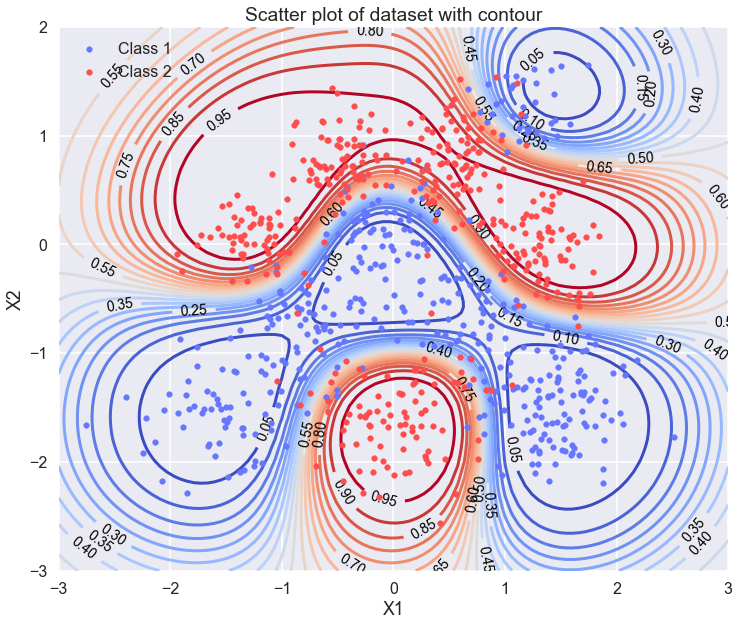

-0.18685330956911983
-0.2241364766373257
[[0.46625 0.03625]
 [0.03125 0.46625]]
[[0.49 0.03]
 [0.04 0.44]]


In [6]:
max_evidence = -9999
max_ell = 0
max_sigma = 0
z = []
    
for ell, sigma in construct_grid():

    model = LaplaceApproximation(split=0.2, rbf_length=10**ell, prior_var=10**sigma)
    model.fit(X, y)

    #model.plot_contour(model.X_train, model.X_train_plot, model.y_train)
    print('Current values: ')
    print('l: ' +str(10**ell) + ' sigma: ' + str(10**sigma))
    #print("Train LL: ")
    #print(model.compute_ll(model.X_train, model.y_train))
    #print("Test LL: ")
    #print(model.compute_ll(model.X_test, model.y_test))
    model_evidence = model.model_evidence()
    z.append(model_evidence)
    if model_evidence > max_evidence and not np.isinf(model_evidence):
        max_evidence = model_evidence
        max_ell = ell
        max_sigma = sigma
    print("Model evidence: ")
    print(model_evidence)
    print(z)
    print("\n\n")

max_model = LaplaceApproximation(split=0.2, rbf_length=10**max_ell, prior_var=10**max_sigma)
max_model.fit(X, y)
    
max_model.plot_contour(max_model.X_train, max_model.X_train_plot, max_model.y_train)

print(max_model.compute_ll(max_model.X_train, max_model.y_train))
print(max_model.compute_ll(max_model.X_test, max_model.y_test))

print(max_model.confusion(max_model.X_train, max_model.y_train))
print(max_model.confusion(max_model.X_test, max_model.y_test))

0.6309573444801934 1.0
-187.00504956179714
-187.00504956179714
-0.19999999999999996 0.0 -187.00504956179714


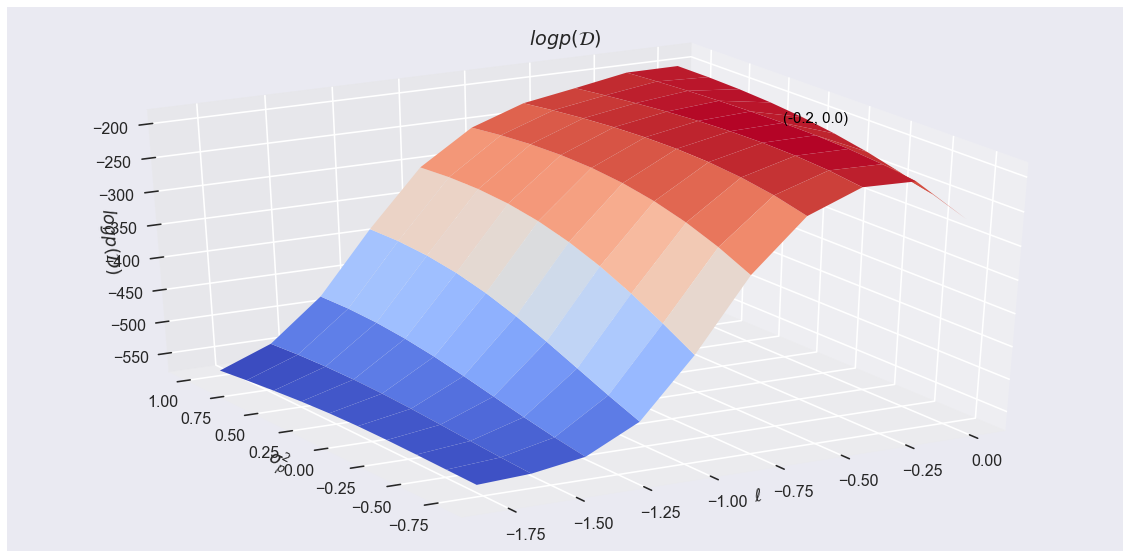

In [110]:
print(10**max_ell, 10**max_sigma)
print(max_model.model_evidence())

ell = np.linspace(-1.8, 0, 10)
sigma = np.linspace(-0.8, 1, 10)
#ell = 10**ell
#sigma = 10**sigma
        
xx, yy = np.meshgrid(ell, sigma)

z_plot = np.reshape(z, (10,10))



zmax = np.where(z_plot == z_plot.max())
xmax = xx[zmax]
ymax = yy[zmax]

print(z_plot.max())

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.text(xmax[0], ymax[0], z_plot.max(), s="(-0.2, 0.0, 187.01)", color='black', fontsize=15)
print(xmax[0], ymax[0], z_plot.max())
ax.view_init(30, -120)
ax.plot_surface(xx, yy, z_plot, cmap='coolwarm')



ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\sigma^{2}_{p}$")
ax.set_zlabel(r'$logp(\mathcal{D})$')
ax.set_title(r'$logp(\mathcal{D})$');

In [8]:
def construct_grid2():
        ell = np.linspace(-1.8, 0, 10)
        sigma = np.linspace(-0.8, 1, 10)
        
        xx, yy = np.meshgrid(ell, sigma)
        
        positions = list(zip(xx.ravel(), yy.ravel()))
        
        return positions